In [26]:
import numpy as np
import pandas as pd

np.random.seed(1)

from pymgrid import Microgrid
from pymgrid.modules import (
    BatteryModule,
    LoadModule,
    RenewableModule,
    GridModule)

In [27]:
small_battery = BatteryModule(min_capacity=10,
                              max_capacity=100,
                              max_charge=50,
                              max_discharge=50,
                              efficiency=0.9,
                              init_soc=0.2)

large_battery = BatteryModule(min_capacity=10,
                              max_capacity=1000,
                              max_charge=10,
                              max_discharge=10,
                              efficiency=0.7,
                              init_soc=0.2)

In [28]:
load_ts = 100+100*np.random.rand(24*90) # random load data in the range [100, 200].
pv_ts = 200*np.random.rand(24*90) # random pv data in the range [0, 200].

load = LoadModule(time_series=load_ts)

pv = RenewableModule(time_series=pv_ts)

In [29]:
grid_ts = [0.2, 0.1, 0.5] * np.ones((24*90, 3))

grid = GridModule(max_import=100,
                  max_export=100,
                  time_series=grid_ts)

In [92]:
grid_ts

array([[0.2, 0.1, 0.5],
       [0.2, 0.1, 0.5],
       [0.2, 0.1, 0.5],
       ...,
       [0.2, 0.1, 0.5],
       [0.2, 0.1, 0.5],
       [0.2, 0.1, 0.5]])

In [110]:
grid.forecast()

In [30]:
modules = [
    small_battery,
    large_battery,
    ('pv', pv),
    load,
    grid]

microgrid = Microgrid(modules)

In [31]:
print(microgrid)

Microgrid([load x 1, pv x 1, balancing x 1, battery x 2, grid x 1])


In [32]:
print(microgrid.modules.pv)

[RenewableModule(time_series=<class 'numpy.ndarray'>, raise_errors=False, forecaster=NoForecaster, forecast_horizon=0, forecaster_increase_uncertainty=False, provided_energy_name=renewable_used)]


In [33]:
print(microgrid.modules.grid is microgrid.modules['grid'])

True


In [34]:
microgrid.controllable

{
  "battery": "[BatteryModule(min_capacity=10, max_capacity=100, max_charge=50, max_discharge=50, efficiency=0.9, battery_cost_cycle=0.0, battery_transition_model=None, init_charge=None, init_soc=0.2, raise_errors=False), BatteryModule(min_capacity=10, max_capacity=1000, max_charge=10, max_discharge=10, efficiency=0.7, battery_cost_cycle=0.0, battery_transition_model=None, init_charge=None, init_soc=0.2, raise_errors=False)]",
  "grid": "[GridModule(max_import=100, max_export=100)]"
}

In [35]:
microgrid.fixed

{
  "load": "[LoadModule(time_series=<class 'numpy.ndarray'>, forecaster=NoForecaster, forecast_horizon=0, forecaster_increase_uncertainty=False, raise_errors=False)]"
}

In [36]:
print(microgrid.get_empty_action())

{'battery': [None, None], 'grid': [None]}


In [37]:
microgrid.reset()
microgrid.state_series.to_frame()

0
load    0 load_current         -172.032449
pv      0 renewable_current      12.523960
battery 0 soc                     0.200000
          current_charge         20.000000
        1 soc                     0.200000
          current_charge        200.000000
grid    0 import_price_current    0.200000
          export_price_current    0.100000
          co2_per_kwh_current     0.500000
          grid_status_current     1.000000

In [38]:
load = -1.0 * microgrid.modules.load.item().current_load
pv = microgrid.modules.pv.item().current_renewable

In [39]:
net_load = load + pv # negative if load demand exceeds pv

if net_load > 0:
    net_load = 0.0

In [40]:
battery_0_discharge = min(-1*net_load, microgrid.modules.battery[0].max_production)
net_load += battery_0_discharge

battery_1_discharge = min(-1*net_load, microgrid.modules.battery[1].max_production)
net_load += battery_1_discharge

In [41]:
grid_import = min(-1*net_load, microgrid.modules.grid.item().max_production)

In [42]:
control = {"battery" : [battery_0_discharge, battery_1_discharge],
           "grid": [grid_import]}

control

{'battery': [9.0, 7.0], 'grid': [100.0]}

In [43]:
obs, reward, done, info = microgrid.run(control, normalized=False)

In [44]:
obs

{'load': [0.4995726232133161],
 'battery': [array([0., 0.]), array([0.18181818, 0.18181818])],
 'grid': [array([0., 0., 0., 0.])],
 'pv': [0.3781555584022365],
 'balancing': [array([], dtype=float64)]}

In [45]:
microgrid.log.loc[:, pd.IndexSlice['load', 0, :]]

module_name     load                         
module_number      0                         
field         reward    load_met load_current
0                0.0  172.032449  -172.032449

In [46]:
microgrid.log.loc[:, pd.IndexSlice['pv', 0, :]]

module_name       pv                                             
module_number      0                                             
field         reward curtailment renewable_used renewable_current
0                0.0         0.0       12.52396          12.52396

In [47]:
microgrid.log.loc[:, 'battery']

module_number      0                                                     \
field         reward discharge_amount charge_amount  soc current_charge   
0               -0.0              9.0           0.0  0.2           20.0   

module_number      1                                                     
field         reward discharge_amount charge_amount  soc current_charge  
0               -0.0              7.0           0.0  0.2          200.0

In [48]:
for _ in range(10):
    microgrid.run(microgrid.sample_action(strict_bound=True))

<Axes: >

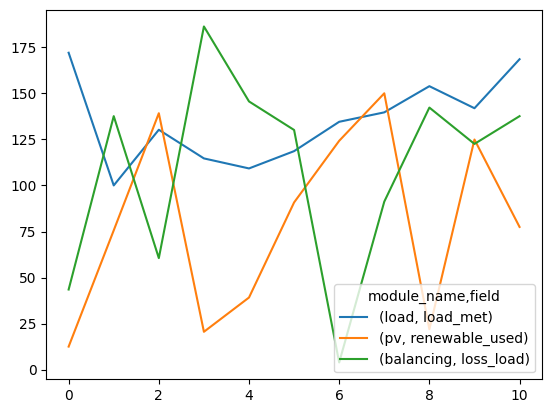

In [49]:
microgrid.log[[('load', 0, 'load_met'),
               ('pv', 0, 'renewable_used'),
               ('balancing', 0, 'loss_load')]].droplevel(axis=1, level=1).plot()

In [74]:
microgrid.get_log()

module_name     load                              pv              \
module_number      0                               0               
field         reward    load_met load_current reward curtailment   
0                0.0  172.032449  -172.032449    0.0         0.0   
1                0.0  100.011437  -100.011437    0.0         0.0   
2                0.0  130.233257  -130.233257    0.0         0.0   
3                0.0  114.675589  -114.675589    0.0         0.0   
4                0.0  109.233859  -109.233859    0.0         0.0   
5                0.0  118.626021  -118.626021    0.0         0.0   
6                0.0  134.556073  -134.556073    0.0         0.0   
7                0.0  139.676747  -139.676747    0.0         0.0   
8                0.0  153.881673  -153.881673    0.0         0.0   
9                0.0  141.919451  -141.919451    0.0         0.0   
10               0.0  168.521950  -168.521950    0.0         0.0   

module_name                                       balancing              \
module_number                                             0               
field         renewable_used renewable_current       reward   loss_load   
0                  12.523960         12.523960  -435.084889   43.508489   
1                  75.621717         75.621717 -1376.183576  137.618358   
2                 139.199302        139.199302  -605.620343   60.562034   
3                  20.563673         20.563673 -1862.923072  186.292307   
4                  39.166847         39.166847 -1456.068553  145.606855   
5                  90.790530         90.790530 -1301.096831  130.109683   
6                 124.229838        124.229838   -39.065025    3.906503   
7                 150.024850        150.024850  -912.178284   91.217828   
8                  21.947004         21.947004 -1422.696122  142.269612   
9                 124.924721        124.924721 -1225.451285  122.545129   
10                 77.472104         77.472104 -1376.119355  137.611935   

module_name                   ...                 grid                      \
module_number                 ...                    0                       
field         overgeneration  ... export_price_current co2_per_kwh_current   
0                        0.0  ...                  0.1                 0.5   
1                        0.0  ...                  0.1                 0.5   
2                        0.0  ...                  0.1                 0.5   
3                        0.0  ...                  0.1                 0.5   
4                        0.0  ...                  0.1                 0.5   
5                        0.0  ...                  0.1                 0.5   
6                        0.0  ...                  0.1                 0.5   
7                        0.0  ...                  0.1                 0.5   
8                        0.0  ...                  0.1                 0.5   
9                        0.0  ...                  0.1                 0.5   
10                       0.0  ...                  0.1                 0.5   

module_name                            balance                                \
module_number                                0                                 
field         grid_status_current       reward overall_provided_to_microgrid   
0                             1.0  -455.084889                    172.032449   
1                             1.0 -1369.240819                    217.813933   
2                             1.0  -601.216051                    199.761336   
3                             1.0 -1854.493412                    206.855981   
4                             1.0 -1448.753542                    184.773702   
5                             1.0 -1292.587508                    220.900213   
6                             1.0   -37.277045                    161.114982   
7                             1.0  -904.733045                    241.242678   
8                      

In [82]:
microgrid.log

module_name     load                              pv              \
module_number      0                               0               
field         reward    load_met load_current reward curtailment   
0                0.0  172.032449  -172.032449    0.0         0.0   
1                0.0  100.011437  -100.011437    0.0         0.0   
2                0.0  130.233257  -130.233257    0.0         0.0   
3                0.0  114.675589  -114.675589    0.0         0.0   
4                0.0  109.233859  -109.233859    0.0         0.0   
5                0.0  118.626021  -118.626021    0.0         0.0   
6                0.0  134.556073  -134.556073    0.0         0.0   
7                0.0  139.676747  -139.676747    0.0         0.0   
8                0.0  153.881673  -153.881673    0.0         0.0   
9                0.0  141.919451  -141.919451    0.0         0.0   
10               0.0  168.521950  -168.521950    0.0         0.0   

module_name                                       balancing              \
module_number                                             0               
field         renewable_used renewable_current       reward   loss_load   
0                  12.523960         12.523960  -435.084889   43.508489   
1                  75.621717         75.621717 -1376.183576  137.618358   
2                 139.199302        139.199302  -605.620343   60.562034   
3                  20.563673         20.563673 -1862.923072  186.292307   
4                  39.166847         39.166847 -1456.068553  145.606855   
5                  90.790530         90.790530 -1301.096831  130.109683   
6                 124.229838        124.229838   -39.065025    3.906503   
7                 150.024850        150.024850  -912.178284   91.217828   
8                  21.947004         21.947004 -1422.696122  142.269612   
9                 124.924721        124.924721 -1225.451285  122.545129   
10                 77.472104         77.472104 -1376.119355  137.611935   

module_name                   ...                 grid                      \
module_number                 ...                    0                       
field         overgeneration  ... export_price_current co2_per_kwh_current   
0                        0.0  ...                  0.1                 0.5   
1                        0.0  ...                  0.1                 0.5   
2                        0.0  ...                  0.1                 0.5   
3                        0.0  ...                  0.1                 0.5   
4                        0.0  ...                  0.1                 0.5   
5                        0.0  ...                  0.1                 0.5   
6                        0.0  ...                  0.1                 0.5   
7                        0.0  ...                  0.1                 0.5   
8                        0.0  ...                  0.1                 0.5   
9                        0.0  ...                  0.1                 0.5   
10                       0.0  ...                  0.1                 0.5   

module_name                            balance                                \
module_number                                0                                 
field         grid_status_current       reward overall_provided_to_microgrid   
0                             1.0  -455.084889                    172.032449   
1                             1.0 -1369.240819                    217.813933   
2                             1.0  -601.216051                    199.761336   
3                             1.0 -1854.493412                    206.855981   
4                             1.0 -1448.753542                    184.773702   
5                             1.0 -1292.587508                    220.900213   
6                             1.0   -37.277045                    161.114982   
7                             1.0  -904.733045                    241.242678   
8                      

In [84]:
microgrid.module_list

[LoadModule(time_series=<class 'numpy.ndarray'>, forecaster=NoForecaster, forecast_horizon=0, forecaster_increase_uncertainty=False, raise_errors=False),
 RenewableModule(time_series=<class 'numpy.ndarray'>, raise_errors=False, forecaster=NoForecaster, forecast_horizon=0, forecaster_increase_uncertainty=False, provided_energy_name=renewable_used),
 UnbalancedEnergyModule(raise_errors=False, loss_load_cost=10.0, overgeneration_cost=2.0),
 BatteryModule(min_capacity=10, max_capacity=100, max_charge=50, max_discharge=50, efficiency=0.9, battery_cost_cycle=0.0, battery_transition_model=None, init_charge=None, init_soc=0.2, raise_errors=False),
 BatteryModule(min_capacity=10, max_capacity=1000, max_charge=10, max_discharge=10, efficiency=0.7, battery_cost_cycle=0.0, battery_transition_model=None, init_charge=None, init_soc=0.2, raise_errors=False),
 GridModule(max_import=100, max_export=100)]

In [88]:
microgrid.modules

{
  "load": "[LoadModule(time_series=<class 'numpy.ndarray'>, forecaster=NoForecaster, forecast_horizon=0, forecaster_increase_uncertainty=False, raise_errors=False)]",
  "pv": "[RenewableModule(time_series=<class 'numpy.ndarray'>, raise_errors=False, forecaster=NoForecaster, forecast_horizon=0, forecaster_increase_uncertainty=False, provided_energy_name=renewable_used)]",
  "balancing": "[UnbalancedEnergyModule(raise_errors=False, loss_load_cost=10.0, overgeneration_cost=2.0)]",
  "battery": "[BatteryModule(min_capacity=10, max_capacity=100, max_charge=50, max_discharge=50, efficiency=0.9, battery_cost_cycle=0.0, battery_transition_model=None, init_charge=None, init_soc=0.2, raise_errors=False), BatteryModule(min_capacity=10, max_capacity=1000, max_charge=10, max_discharge=10, efficiency=0.7, battery_cost_cycle=0.0, battery_transition_model=None, init_charge=None, init_soc=0.2, raise_errors=False)]",
  "grid": "[GridModule(max_import=100, max_export=100)]"
}

In [162]:
microgrid.to_yaml()

TypeError: Microgrid.to_yaml() missing 2 required positional arguments: 'dumper' and 'data'